In [ ]:
"""
Group_Project Colab.ipynb

This script implements a Convolutional Neural Network (CNN) for binary image classification
(NORMAL vs. PNEUMONIA) using the TensorFlow and Keras libraries. It includes data preprocessing,
model training, evaluation, and visualization of performance metrics.

"""

# Import necessary libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import calibration_curve
from google.colab import drive

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
drive.mount('/content/drive')
!ls '/content/drive/MyDrive/CSCK506 Group Project'

os.chdir('/content/drive/MyDrive/CSCK506 Group Project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 best_model.keras	  'Group_Project Colab.ipynb'   model90.h5
 chest_xray_Oversampling   history.json		        Oversampling.ipynb


In [ ]:
# Data directory choices for training, validation, and testing datasets
data_dir_choice = ['chest_xray_Raw', 'chest_xray_Oversampling', 'chest_xray_Undersampling']
data_dir = data_dir_choice[1]  # **CHANGED** Selected Oversampling as the dataset

# Data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescaling for validation and test datasets
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Directory paths
train_dir = f'{data_dir}/train'
val_dir = f'{data_dir}/val'
test_dir = f'{data_dir}/test'

# Model hyperparameters
batch_size = 32
img_height, img_width = 224, 224

# Data generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)



Found 7750 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


       Class  Train Count  Validation Count  Test Count
0     NORMAL         3875                 8         234
1  PNEUMONIA         3875                 8         390


<Axes: xlabel='Class'>

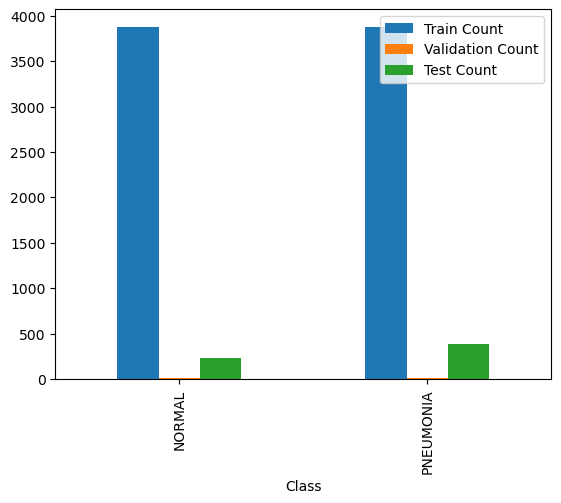

In [ ]:
# Extract class labels from generators
train_labels = train_generator.classes
val_labels = val_generator.classes
test_labels = test_generator.classes

# Count the number of samples in each class
train_class_counts = np.bincount(train_labels)
val_class_counts = np.bincount(val_labels)
test_class_counts = np.bincount(test_labels)

# Create a summary DataFrame of class distribution
class_labels = list(train_generator.class_indices.keys())


train_df = pd.DataFrame({
    'Class': class_labels,
    'Train Count': train_class_counts
})

val_df = pd.DataFrame({
    'Class': class_labels,
    'Validation Count': val_class_counts
})

test_df = pd.DataFrame({
    'Class': class_labels,
    'Test Count': test_class_counts
})

# Print and visualize class distribution
df_distribution = pd.merge(train_df, val_df, on='Class')
df_distribution = pd.merge(df_distribution, test_df, on='Class')

print(df_distribution)

df_distribution.set_index('Class').plot(kind='bar', stacked=False)


In [ ]:
# Calculate class weights to handle class imbalance

class_labels = train_generator.classes

class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

class_weight_dict


{0: 1.0, 1: 1.0}

In [ ]:
# Define the CNN model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2), padding='same'),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()



C:\Users\roy.fong\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_96 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_96 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_97 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_98 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_99 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_25     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,441 (1.61 MB)

 Trainable params: 421,441 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks to handle early stopping, learning rate reduction, and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

Epoch 1/20


C:\Users\roy.fong\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


243/243 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.6688 - loss: 0.5868 - val_accuracy: 0.6875 - val_loss: 1.6213 - learning_rate: 0.0010
Epoch 2/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 341s 1s/step - accuracy: 0.8269 - loss: 0.4354 - val_accuracy: 0.7500 - val_loss: 0.7986 - learning_rate: 0.0010
Epoch 3/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.8708 - loss: 0.3557 - val_accuracy: 0.6250 - val_loss: 0.7838 - learning_rate: 0.0010
Epoch 4/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - accuracy: 0.8782 - loss: 0.3253 - val_accuracy: 0.6250 - val_loss: 1.0691 - learning_rate: 0.0010
Epoch 5/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.8944 - loss: 0.2818 - val_accuracy: 0.6875 - val_loss: 0.6522 - learning_rate: 0.0010
Epoch 6/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.8998 - loss: 0.2782 - val_accuracy: 0.6875 - val_loss: 1.1632 - learning_rate: 0.0010
Epoch 7/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.9067 - loss: 0.2460 - val_

In [ ]:
# Save the trained model and history
'''
model.save('model90.h5')

with open('training_history.json', 'w') as f:
    json.dump(history.history, f)'''

# Load the training model and history
'''
model = load_model('model90.h5')

with open('history.json', 'r') as f:
    loaded_history = json.load(f)
print(loaded_history)
history = loaded_history'''

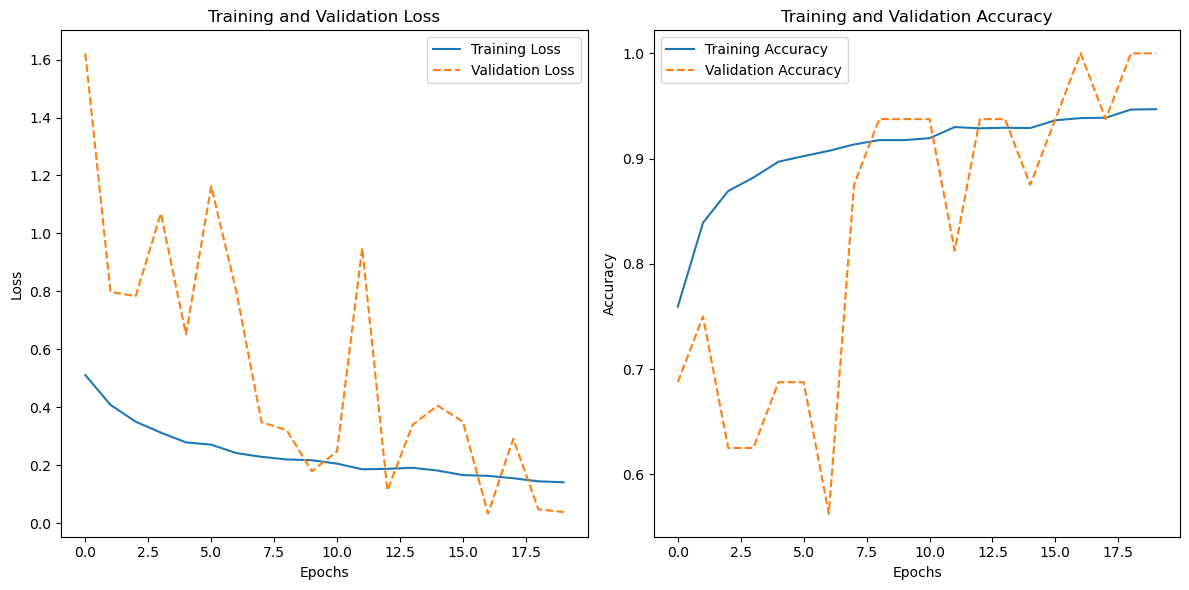

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8926 - loss: 0.3488
Test Loss: 0.2859283685684204
Test Accuracy: 0.8958333134651184


In [ ]:
# Make predictions on the test set
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int').flatten()

20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step


In [ ]:
# Generate classification report
true_labels = test_generator.classes
print(classification_report(true_labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       234
           1       0.92      0.91      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



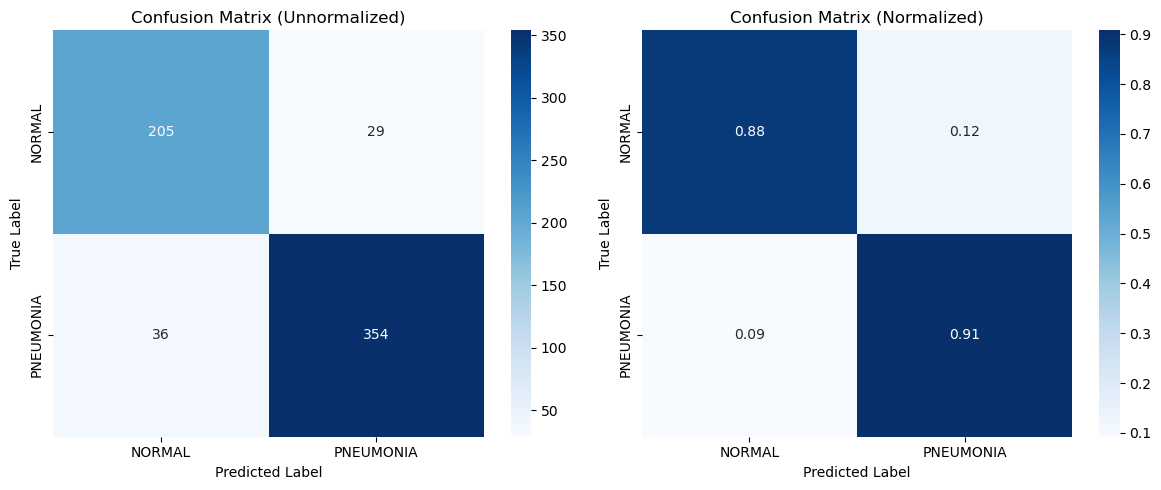

In [ ]:
true_labels = test_generator.classes

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Unnormalized confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(), ax=axes[0])
axes[0].set_title("Confusion Matrix (Unnormalized)")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(), ax=axes[1])
axes[1].set_title("Confusion Matrix (Normalized)")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()

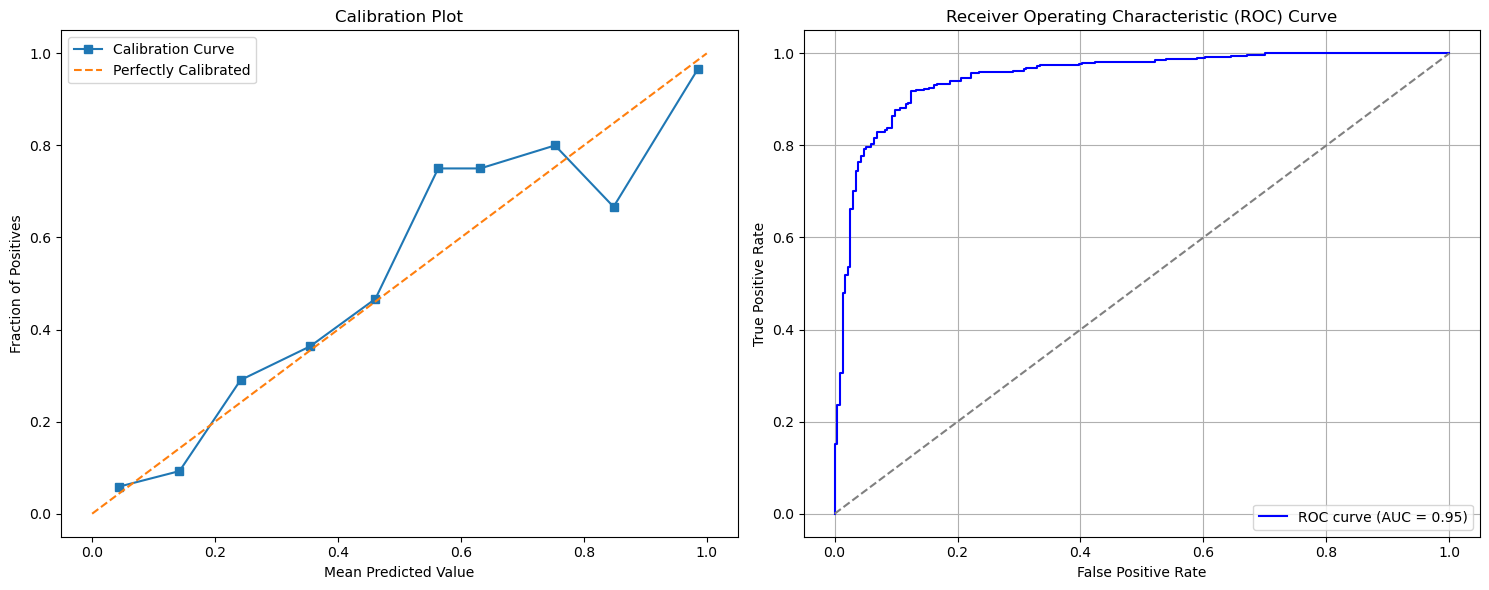

In [ ]:
# Calibration Plot
fraction_of_positives, mean_predicted_value = calibration_curve(true_labels, predictions, n_bins=10)

# ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Calibration Plot on the left
axes[0].plot(mean_predicted_value, fraction_of_positives, "s-", label="Calibration Curve")
axes[0].plot([0, 1], [0, 1], linestyle="--", label="Perfectly Calibrated")
axes[0].set_xlabel("Mean Predicted Value")
axes[0].set_ylabel("Fraction of Positives")
axes[0].set_title("Calibration Plot")
axes[0].legend()

# ROC Curve on the right
axes[1].plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc='lower right')
axes[1].grid(True)

# Show the plots side by side
plt.tight_layout()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


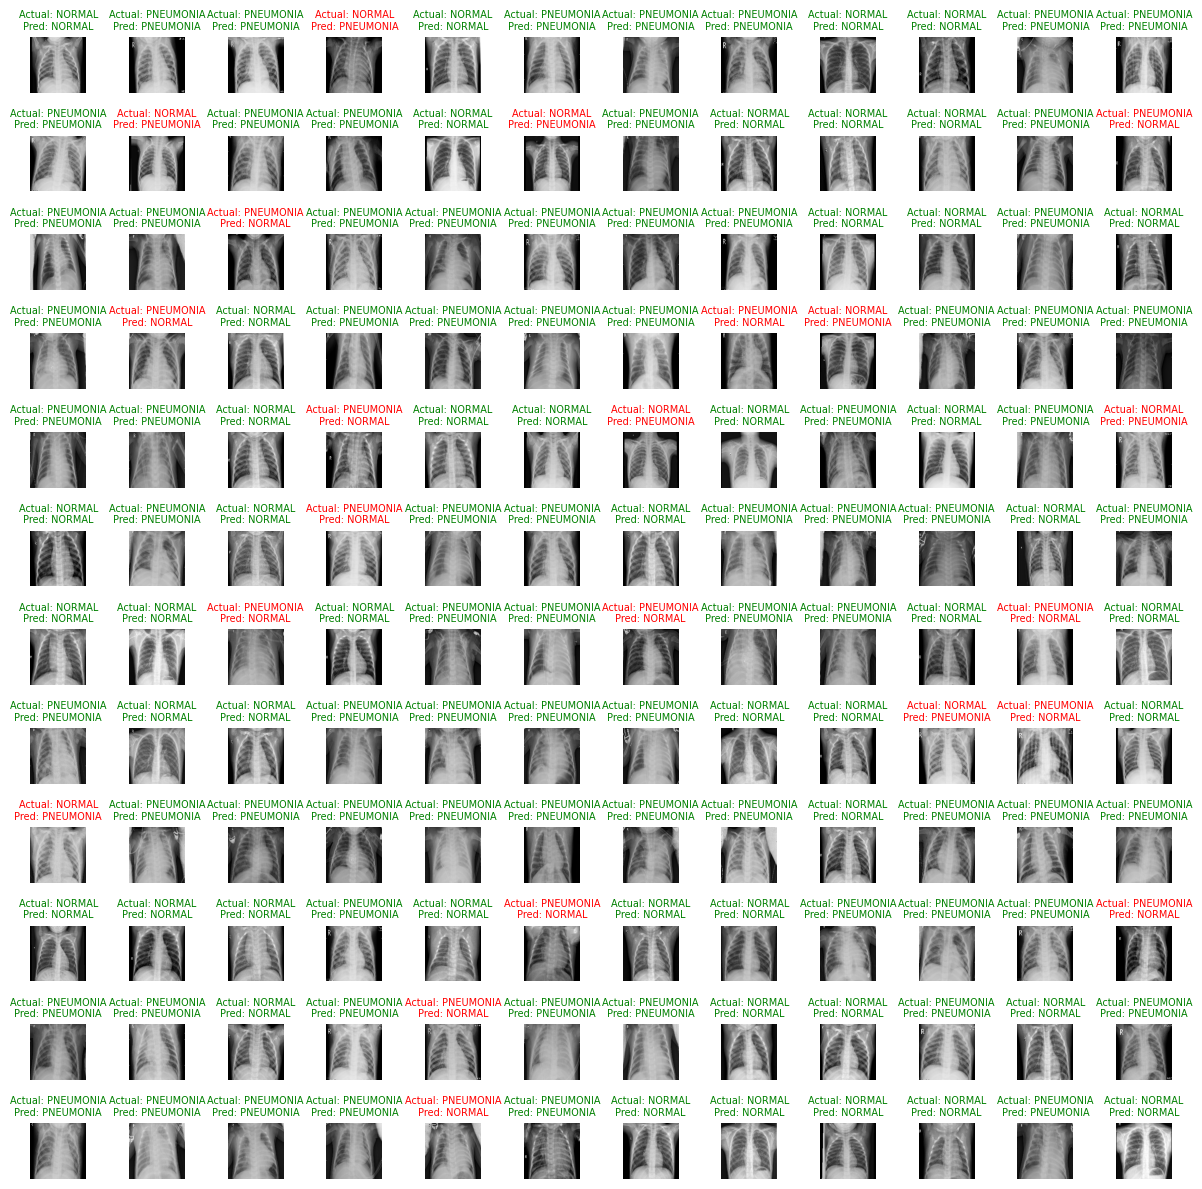

In [ ]:
class_labels = {0: 'NORMAL', 1: 'PNEUMONIA'}

# Parameters for image processing and display
img_size = (150, 150)  # Image size to resize to
num_images_to_show = 144
rows, cols = 12, 12

# Collect all images and labels
image_paths = []
labels = []

# Loop through subdirectories NORMAL and PNEUMONIA
for label, class_name in class_labels.items():
    class_dir = os.path.join(test_dir, class_name)
    if os.path.exists(class_dir):
        for img_file in os.listdir(class_dir):
            if img_file.lower().endswith('jpeg'):  # Image file extensions
                image_paths.append(os.path.join(class_dir, img_file))
                labels.append(label)

# Randomly sample images
random_indices = random.sample(range(len(image_paths)), min(num_images_to_show, len(image_paths)))
sampled_image_paths = [image_paths[i] for i in random_indices]
sampled_labels = [labels[i] for i in random_indices]

# Load images and prepare for prediction
batch_images = np.array([img_to_array(load_img(img_path, target_size=img_size)) / 255.0 for img_path in sampled_image_paths])
actual_labels = np.array(sampled_labels)

# Make predictions
predictions = model.predict(batch_images)
predicted_classes = (predictions > 0.5).astype('int').flatten()

# Plotting
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

for i, img_path in enumerate(sampled_image_paths):
    row, col = divmod(i, cols)
    ax = axes[row, col]

    # Display image
    ax.imshow(load_img(img_path, target_size=img_size))
    ax.axis('off')

    # Get actual and predicted labels
    actual_label = actual_labels[i]
    predicted_label = predicted_classes[i]

    actual_str = class_labels[actual_label]
    predicted_str = class_labels[predicted_label]

    # Set title color based on correctness
    title_color = 'green' if actual_label == predicted_label else 'red'

    # Set subplot title
    ax.set_title(f"Actual: {actual_str}\nPred: {predicted_str}", color=title_color, fontsize=7)

# Turn off unused subplots
for i in range(len(sampled_image_paths), rows * cols):
    row, col = divmod(i, cols)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()